In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import SMOTE

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_excel('./Data/File1.xlsx')

## Feature Engineering

---

In my discussions with my SME there were two fields that were very important in helping to determine if someone will repay their loan.

- OOS Date: This is the out of statute date, which is the last date any litigation can be brought. The further away from this date the more likely you are to collect. I subtracted the date this portfolio was purchased from this date to get that number
- Cycle: This is the number of times the loan have been sent out for collection. Typically the fewer times collection attempts the more likely you are to collect.

In [3]:
# Date the protfolio was purchased
purchased_dt = pd.to_datetime('10/24/2008')

# Calculate the days until Out of Statute
df['OOS Days Left'] = df['OOS Date'] - purchased_dt
df['OOS Days Left int'] = 0

for i, _ in df.iterrows():
    days = df.iloc[i]['OOS Days Left'].days
    df.iloc[i,29] = days

In [4]:
# Dummy up the Cycle as this is an important feature
df = pd.get_dummies(df, columns = ['Cycle'])
df.columns

Index(['Account Number', 'PortID', 'Remaining Balance', 'interests Fees',
       'Date Opened', 'Charge Off Date', 'Last Pay Date', 'Last Pay Amount',
       'Last Activity Date', 'Interest Rate %', 'Issuer', 'Merchant',
       'FCFRA Date', 'OOS Date', 'Account Type', 'Last Name', 'First Name',
       'Middle Name', 'Address', 'City', 'State', 'Zip', 'County', 'SSN',
       'Home Phone', 'Employer Phone', 'Paid', 'OOS Days Left',
       'OOS Days Left int', 'Cycle_QUATERNARY', 'Cycle_SECONDARY',
       'Cycle_TERTIARY'],
      dtype='object')

## Write out the cleaned data

In [5]:
# Write out the new .csv file
df.to_csv("./Data/cleaned.csv", index=False)

## Creating the features for the model
In my discussions with my SME there are 6 features that will be the best in determining the likelihood of someone repaying their loan.

- Remaining Balance
- Interest Rate %
- interests Fees
- Last Pay Amount
- OOS Date: I'll use the number of day until that date which I calculated above
- Cycle: I'll use the dummies that I created above


In [6]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add others to drop list
drop_cols.extend(('Paid','Account Number','SSN','Home Phone',
                  'Employer Phone','OOS Days Left'))

In [7]:
num_cols

Index(['Account Number', 'Remaining Balance', 'interests Fees',
       'Last Pay Amount', 'Interest Rate %', 'SSN', 'Home Phone',
       'Employer Phone', 'Paid', 'OOS Days Left', 'OOS Days Left int',
       'Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY'],
      dtype='object')

In [8]:
drop_cols

['PortID',
 'Date Opened',
 'Charge Off Date',
 'Last Pay Date',
 'Last Activity Date',
 'Issuer',
 'Merchant',
 'FCFRA Date',
 'OOS Date',
 'Account Type',
 'Last Name',
 'First Name',
 'Middle Name',
 'Address',
 'City',
 'State',
 'Zip',
 'County',
 'Paid',
 'Account Number',
 'SSN',
 'Home Phone',
 'Employer Phone',
 'OOS Days Left']

## Getting Ready To Model

In [9]:
y = df['Paid']
X = df.drop(columns = drop_cols)
X_col = X

### Gridsearch Function
Looking for the best hyperparameters for the passed in model

In [10]:
def build_model(model, model_params, X, y):
    loocv = LeaveOneOut()
    model = model
    
    gs = GridSearchCV(model, param_grid=model_params, cv=loocv, n_jobs=3)
    gs.fit(X, y);

    print('Best parameters',gs.best_params_)

    # Model Accuracy, how often is the classifier correct
    accuracy = gs.score(X, y)
    print('Score: %.2f%%' % (accuracy * 100.0))

### LeaveOneOut Function
Because the dataset is very small I'm using the leave one out method for training and testing. This function also prints out the metric scores and plots the ROC curve.

In [45]:
def leave_one_out(algr, X, y):
    loocv = LeaveOneOut()
        
    for train_index, test_index in loocv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = algr.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    print('Train Accuracy: %.2f%%' % (accuracy * 100.0))

    precision = metrics.precision_score(y_train, y_train_pred)
    print('Train Precision: %.2f%%' % (precision * 100.0))

    recall = metrics.recall_score(y_train, y_train_pred)
    print('Train Recall: %.2f%%' % (recall * 100.0))
    
    
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    print('Test Accuracy: %.2f%%' % (accuracy * 100.0))

    precision = metrics.precision_score(y_test, y_test_pred)
    print('Test Precision: %.2f%%' % (precision * 100.0))

    recall = metrics.recall_score(y_test, y_test_pred)
    print('Test Recall: %.2f%%' % (recall * 100.0))
    
    
    cvs = cross_val_score(algr, X, y, cv=loocv)
    print("Cross Validation Score: %.2f%%" % (cvs.mean()*100.0))

    y_pred_proba = algr.predict_proba(X)[::,1]


    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)

    roc_auc = metrics.auc(fpr,tpr)

    # Plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### Stratified K-fold Cross Validation Function
Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole. For example, in a binary classification problem where each class comprises of 50% of the data, it is best to arrange the data such that in every fold, each class comprises of about half the instances.

Because the data set is small this will Randomly split your entire dataset into k”folds” with each class comprising 50% of the data.

In [12]:
def skfcv(model, X, y):
    skf_score = []

    skf = StratifiedKFold(n_splits=sum(y==1), random_state=None)

    for train_index, test_index in skf.split(X,y): 

        X_train_fold, X_test_fold = X[train_index], X[test_index] 
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        fold_model = model.fit(X_train_fold, y_train_fold)

        skf_score.append(fold_model.score(X_test_fold, y_test_fold))
        
    print("StratifiedKFold Score: %.2f%%" % (np.mean(skf_score)*100.0))    

### SMOTE (Synthetic Minority Over-sampling Technique)
Because the dataset out of balanced I'm over sampling the minority class.

In [13]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(k_neighbors=3,random_state=42)
X, y = sm.fit_sample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

Before OverSampling, counts of label '1': 5
Before OverSampling, counts of label '0': 37 

After OverSampling, the shape of train_X: (74, 8)
After OverSampling, the shape of train_y: (74,) 

After OverSampling, counts of label '1': 37
After OverSampling, counts of label '0': 37


## Fitting and making predictions with the Logistic Regression model.

---

### Gridsearch to find best parameters

In [14]:
params = {
    'class_weight':['balanced',None],
    'fit_intercept':[True,False],
    'solver':['liblinear'],
    'C':[0.001,0.01,0.1,1,10,100],
    'penalty':['l1','l2'],
    'random_state':[42],
}
build_model(LogisticRegression(), params, X, y)

Best parameters {'C': 100, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Score: 90.54%


Train Accuracy: 90.41%
Train Precision: 89.19%
Train Recall: 91.67%
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Cross Validation Score: 86.49%
StratifiedKFold Score: 86.49%


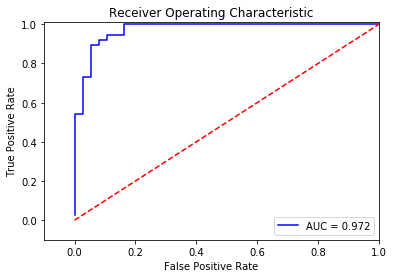

In [46]:
logreg = LogisticRegression(C=100,
                            class_weight='balanced',
                            fit_intercept=True,
                            penalty='l1',
                            solver='liblinear',
                            random_state=42
                            )

leave_one_out(logreg, X, y)
skfcv(logreg, X, y)

# Logistic Regression Model Evaluation
#### Confusion Matrix

Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of for the training set was 90.41%. The test set scored 100%.  

- Precision: How accurate is your model. In other words, you can say, when a model makes a prediction, how often it is correct. In this case, the training set scored 89.19% and the test was correct 100% of the time.

- Recall: If there are debtors who have paid in the training set this model can identify them 91.67% of the time. In the test set it can identify them 100% of the time

#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case was 0.972. AUC score 1 represents perfect classifier.

#### Cross Validation Score
The cross validation score was 86.49%

#### StratifiedKFold
The Stratified KFold Score was 86.49%

#### Overall Evaluation
Based on all the scores I think that this might be a good model, even though the test set was 100%. The observations from the test set might come from the fact that there is only one observations in that set. However the cross-validation and Stratified KFold scores were very good.

## Fitting and making predictions with DecisionTreeClassifier model.

---

### Gridsearch to find best parameters

In [16]:
params = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'class_weight':['balanced',None],
    'max_depth':[1,2],
    'min_samples_leaf':[1],
    'min_samples_split':[0.0001,0.001],
    'min_weight_fraction_leaf':[0.01,0.001],
    'random_state':[42]
}
build_model(DecisionTreeClassifier(), params, X, y)

Best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 0.0001, 'min_weight_fraction_leaf': 0.01, 'random_state': 42, 'splitter': 'best'}
Score: 93.24%


### Build model with best parameters

Train Accuracy: 93.15%
Train Precision: 87.80%
Train Recall: 100.00%
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Cross Validation Score: 86.49%
StratifiedKFold Score: 77.03%


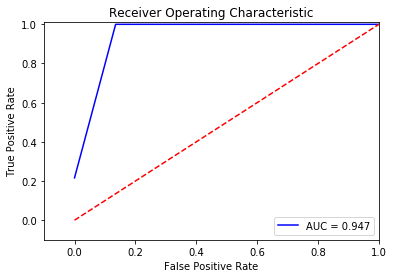

In [47]:
dt = DecisionTreeClassifier(class_weight='balanced',
                            criterion='gini',
                            max_depth=2,
                            min_samples_leaf=1,
                            min_samples_split=0.0001,
                            min_weight_fraction_leaf=0.001,
                            random_state=42,
                            splitter='best')
leave_one_out(dt, X, y)
skfcv(dt, X, y)

### What are the important features to this model

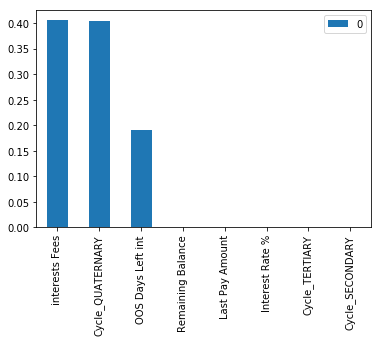

In [18]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = dt.feature_importances_

importances = list(zip(dt.feature_importances_, X_col.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

### DecisionTreeClassifier Model Evaluation
#### Confusion Matrix

Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of for the training set was 95.15%. The test set scored 100%.  

- Precision: How accurate is your model. In other words, you can say, when a model makes a prediction, how often it is correct. In this case, the training set scored 87.80% and the test was correct 100% of the time.

- Recall: If there are debtors who have paid in the training set this model can identify them 100% of the time. In the test set it can identify them 100% of the time

#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case was 0.947. AUC score 1 represents perfect classifier.

#### Cross Validation Score
The cross validation score was 86.49%

#### StratifiedKFold
The Stratified KFold Score was 77.03%

#### Overall Evaluation
Based on all the scores I think that this might be a ok model, even though the test set was 100%. The observations from the test set might come from the fact that there is only one observations in that set. However the cross-validation and Stratified KFold scores did not match very well. 

## Fitting and making predictions with RandomForestClassifier model.

-----

### Gridsearch to find best parameters

In [29]:
params = {
    'criterion':['gini','entropy'],
    'class_weight':['balanced',None],
    'n_estimators':[9,11],
    'max_depth':[1,2],
    'min_samples_leaf':[2,3],
    'min_samples_split':np.linspace(0.00001, 0.1, 15),
    'random_state':[42]
}
build_model(RandomForestClassifier(), params,  X, y)

Best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 0.07143142857142858, 'n_estimators': 9, 'random_state': 42}
Score: 91.89%


### Build model with best parameters

Train Accuracy: 91.78%
Train Precision: 85.71%
Train Recall: 100.00%
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Cross Validation Score: 94.59%
StratifiedKFold Score: 90.54%


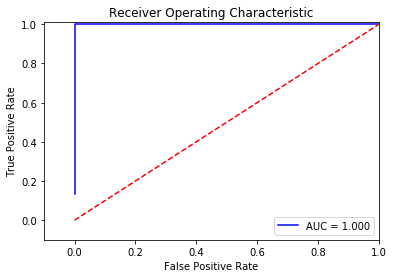

In [48]:
rf = RandomForestClassifier(class_weight='balanced',
                            criterion='gini',
                            max_depth=2,
                            min_samples_leaf=2,
                            min_samples_split=0.0714,
                            n_estimators=9,
                            random_state=42)
leave_one_out(rf, X, y)
skfcv(rf, X, y)

### What are the important features to this model

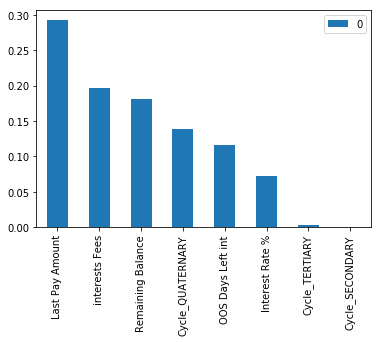

In [31]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = rf.feature_importances_

importances = list(zip(rf.feature_importances_, X_col.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

### RandomForestClassifier Model Evaluation
#### Confusion Matrix

Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of for the training set was 91.78%. The test set scored 100%.  

- Precision: How accurate is your model. In other words, you can say, when a model makes a prediction, how often it is correct. In this case, the training set scored 85.71% and the test was correct 100% of the time.

- Recall: If there are debtors who have paid in the training set this model can identify them 100% of the time. In the test set it can identify them 100% of the time

#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case was 0.947. AUC score 1 represents perfect classifier.

#### Cross Validation Score
The cross validation score was 94.59%

#### StratifiedKFold
The Stratified KFold Score was 90.54%

#### Overall Evaluation
Based on all the scores I think that this might be a good model, even though the test set was 100%. The observations from the test set might come from the fact that there is only one observations in that set. However the cross-validation and Stratified KFold scores were very good.

## Fitting and making predictions with Gradient Boost model.

---

### Gridsearch to find best parameters

In [32]:
params = {
    'n_estimators':[5,7,9],
    'learning_rate':[.01,.001,.1],
    'max_depth':[1,2,3],
    'loss':['deviance'],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':np.linspace(0.00001, 0.1, 15),
    'random_state':[42]
}
build_model(GradientBoostingClassifier(), params, X, y)

Best parameters {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 1e-05, 'n_estimators': 7, 'random_state': 42}
Score: 97.30%


### Build model with best parameters

Train Accuracy: 95.89%
Train Precision: 92.31%
Train Recall: 100.00%
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Cross Validation Score: 91.89%
StratifiedKFold Score: 91.89%


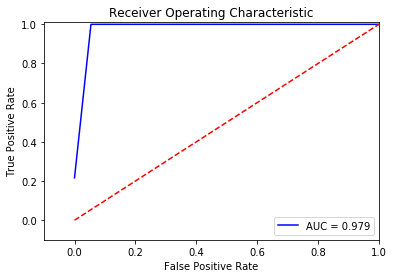

In [33]:
grad_boost = GradientBoostingClassifier(learning_rate=0.01,
                                        loss='deviance',
                                        max_depth=3,
                                        min_samples_leaf=1,
                                        min_samples_split=0.00001,
                                        n_estimators=7,
                                        random_state=42)
leave_one_out(grad_boost, X, y)
skfcv(grad_boost, X, y)

### What are the important features to this model

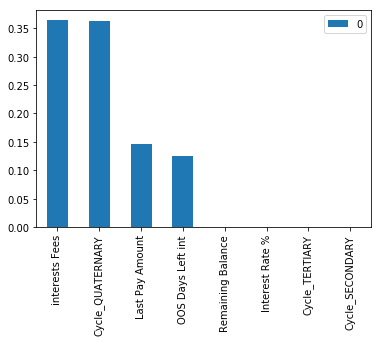

In [34]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = grad_boost.feature_importances_

importances = list(zip(grad_boost.feature_importances_, X_col.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar');

### Gradient Boost Model Evaluation
#### Confusion Matrix

Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of for the training set was 95.89%. The test set scored 100%.  

- Precision: How accurate is your model. In other words, you can say, when a model makes a prediction, how often it is correct. In this case, the training set scored 92.31% and the test was correct 100% of the time.

- Recall: If there are debtors who have paid in the training set this model can identify them 100% of the time. In the test set it can identify them 100% of the time

#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case was 0.979. AUC score 1 represents perfect classifier.

#### Cross Validation Score
The cross validation score was 91.89%

#### StratifiedKFold
The Stratified KFold Score was 91.89%

#### Overall Evaluation
Based on all the scores I think that this might be a good model, even though the test set was 100%. The observations from the test set might come from the fact that there is only one observations in that set. However the cross-validation and Stratified KFold scores were very good.

## Fitting and making predictions with KNeighborsClassifier model.

---

#### Instantiate KNN

For the `KNeighborsClassifier`, there a few important parameters to keep in mind:

1. `n_neighbors`: this is the "K" in KNN. The best K will change from problem to problem, but the default is 5.
2. `weights`: The neighbors can all have an equal vote (`uniform`), or the closer points can have a higher weighted vote (`distance`).
3. `p`: The distance metric. The default is Euclidean distance (2). Changing it to 1 is setting the distance to Manhattan.

In the cell below, instantiate a `knn` model using the default parameters.

In [35]:
# Because these are dummy vaiables scaling is not required
features = ['Cycle_QUATERNARY', 
            'Cycle_SECONDARY', 
            'Cycle_TERTIARY', 
           ]

X_knn = df[features]
y_knn = df['Paid']

### SMOTE (Synthetic Minority Over-sampling Technique)

In [37]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_knn==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_knn==0)))

sm = SMOTE(k_neighbors=3,random_state=42)
X_res, y_res = sm.fit_sample(X_knn, y_knn)

print('After OverSampling, the shape of X_res: {}'.format(X_res.shape))
print('After OverSampling, the shape of y_res: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

Before OverSampling, counts of label '1': 5
Before OverSampling, counts of label '0': 37 

After OverSampling, the shape of X_res: (74, 3)
After OverSampling, the shape of y_res: (74,) 

After OverSampling, counts of label '1': 37
After OverSampling, counts of label '0': 37


### Gridsearch to find best parameters

In [38]:
params = {
    'n_neighbors':[3,5,7],
    'algorithm':['auto']
}
build_model(KNeighborsClassifier(), params, X_res, y_res)

Best parameters {'algorithm': 'auto', 'n_neighbors': 3}
Score: 59.46%


### Build model with best parameters

Train Accuracy: 58.90%
Train Precision: 100.00%
Train Recall: 16.67%
Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Cross Validation Score: 59.46%
StratifiedKFold Score: 86.49%


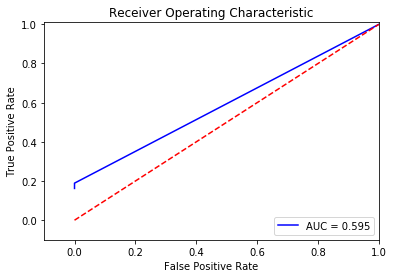

In [39]:
knn = KNeighborsClassifier(algorithm='auto',
                           n_neighbors=3)

leave_one_out(knn, X_res, y_res)
skfcv(knn, X, y)

### KNeighborsClassifier Model Evaluation
#### Confusion Matrix

Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of for the training set was 58.9%. The test set scored 100%.  

- Precision: How accurate is your model. In other words, you can say, when a model makes a prediction, how often it is correct. In this case, both the training set the test was correct 100% of the time.

- Recall: If there are debtors who have paid in the training set this model can identify them 16.67% of the time. In the test set it can identify them 100% of the time

#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case was 0.595. AUC score 1 represents perfect classifier.

#### Cross Validation Score
The cross validation score was 59.46%

#### StratifiedKFold
The Stratified KFold Score was 86.49%

#### Overall Evaluation
Based on all the scores I think that this is a bad model, even though the test set was 100%. The observations from the test set might come from the fact that there is only one observations in that set. However the cross-validation and Stratified KFold scores did not match very well. Also, the low accuracy and recall scores on the test set make this model not better then chance.